In [25]:
from IPython.display import Image
import pandas as pd

# Raw Sequencing Data Processing Pipeline
## Written By: Kathryn Cogert 10/23/18

Intended for MacOSX users with some familiarity with command consoles

Requirements:

- Software & Scripts
 - FastQC (optional)
 - usearch
- Files
    - Raw Sequences in data/ directory of format:
     - Forward Reads: *_R1_001.fastq
     - Reverse Reads: *_R2_001.fastq
    - mapping file for demultiplexing: usearch_mapping.txt
    - _split_demux_fastq.py (a script written by Sam to seperate samples into unqiue files)
    - mapping file for seperating related samples into unique files: split_map.txt
    - silva.seed_v132.usearch.fasta (cleaned by Sam)
 

### Step 1. Unzip raw data

Skipping this time, this data was already merged.

! gunzip -k -f data/*.gz 

### Step 2. Examine quality scores of forward and reverse reads

Examining quality of cleaned sequences instead.


This step is not essential to the pipeline but is a valuable check to see if your sequencing data is of good quality.  This requires the FastQC Program.  If you do not have it, download the linux installer at:

https://www.bioinformatics.babraham.ac.uk/projects/download.html#fastqc 

And follow the linux installation directions, being sure to replace "/path/to/" with the path to the location of the unzipped folder.  This will allow you to run fastqc from the command line



In [3]:
! mkdir fastqc_out
! fastqc data/*.fastq -outdir fastqc_out
! unzip 'fastqc_out/*.zip' -d fastqc_out -o

Started analysis of KC.fastq
Approx 5% complete for KC.fastq
Approx 10% complete for KC.fastq
Approx 15% complete for KC.fastq
Approx 20% complete for KC.fastq
Approx 25% complete for KC.fastq
Approx 30% complete for KC.fastq
Approx 35% complete for KC.fastq
Approx 40% complete for KC.fastq
Approx 45% complete for KC.fastq
Approx 50% complete for KC.fastq
Approx 55% complete for KC.fastq
Approx 60% complete for KC.fastq
Approx 65% complete for KC.fastq
Approx 70% complete for KC.fastq
Approx 75% complete for KC.fastq
Approx 80% complete for KC.fastq
Approx 85% complete for KC.fastq
Approx 90% complete for KC.fastq
Approx 95% complete for KC.fastq
Analysis complete for KC.fastq
Archive:  fastqc_out/KC_fastqc.zip
caution: filename not matched:  -o

1 archive had fatal errors.


### Read Quality:

For Illumina sequecning it's typical to see read lengths between 30-350 bp long, note if any sequences in particular are flagged as poor quality.  It is also typical for quality to drop off with read length

Archive:  fastqc_out/KC_fastqc.zip
caution: filename not matched:  -n
##FastQC	0.11.8
>>Basic Statistics	pass
#Measure	Value
Filename	KC.fastq
File type	Conventional base calls
Encoding	Sanger / Illumina 1.9
Total Sequences	288760
Sequences flagged as poor quality	0
Sequence length	17-523
%GC	54


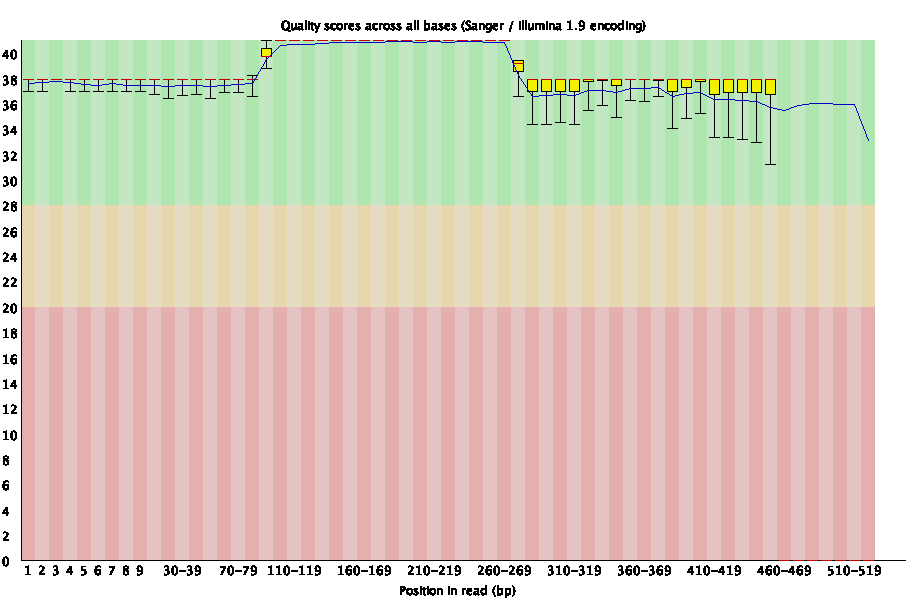

In [26]:
! unzip fastqc_out/*.zip -n
! head -10 KC_fastqc/fastqc_data.txt
img_f = "KC_fastqc/Images/per_base_quality.png"
Image(filename=glob.glob(img_f)[0])


### Reverse Read Quality:

Skipping, reads already merged.

Same as above, but it is typical for reverse reads to be slightly worse in quality than forward reads.

! head -10 fastqc_out/*_R2_001_fastqc/fastqc_data.txt
img_f = "fastqc_out/*_R2_001_fastqc/Images/per_base_quality.png"
Image(filename=glob.glob(img_f)[0])

### Step 3. Merge forward and reverse reads

Skipping, reads already merged.

This step aligns the forward and reverse reads,  I have used Sam's recommended minimum overlap of 32 bp.  If you want to be very conservative, you can use 45.


! usearch -fastq_mergepairs data/*_R1_001.fastq -reverse data/*_R2_001.fastq -fastqout merged.fastq -fastq_minovlen 32

### Step 4. Demultiplex data

Skipping, already de-multiplexed

This data contains many different samples. Each sample has a unique barcode, this step looks for those barcodes in order to seperate the different samples from one another.

This requires a mapping file, usearch_mapping.txt of format:

\> SAMPLE.NAME <br>
ATCCGAAA (I just made up this barcode)

! usearch -fastx_demux merged.fastq -barcodes usearch_mapping.txt -fastqout demux.fastq

### Step 5. Trim barcodes and primers

Now that samples are seperated by barcode, we don't need the barcodes anymore. While we're at it, we can get rid of the primers used in the sequencing.

! usearch -fastx_truncate demux.fastq -stripleft 27 -stripright 20 -fastqout trimmed.fastq

### Step 6. Split related samples into unqiue files
Skipping, already split

We can now put all of the related samples in their own files, this allows us to focus in on the experiment that we want to examine.

! python _split_demux_fastq.py -f trimmed.fastq -m split_map.txt 

### Step 7. Concatenate samples from a different sequence for comparison

Skipping for now...

We will now continue analysis only on the AMX sample from the sequencing set as well as the Tacoma and Rotterdam samples from a previous sequencing set. In order to do that, we need to concatenate the two files

! cat AMX.fastq Tacoma_and_Rotterdam_seed.fastq > All_Amx.fastq

### Step 7. Filter sequences with errors out

We will now filter out all sequences with more than 1 error.  This algorithm may also do some additional filtration and cleaning as well.

In [27]:
! usearch10 -fastq_filter data/KC.fastq -fastq_maxee 1.0 -fastaout AMX.filtered.fasta

usearch v10.0.240_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-17 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

License: cogerk@gmail.com

00:12 2.0Mb   100.0% Filtering, 97.4% passed
    288760  Reads (288.8k)                  
      7543  Discarded reads with expected errs > 1.00
    281217  Filtered reads (281.2k, 97.4%)


### Step 8. Relabel individual sequence

Each sequence is given an index number here.

In [28]:
! usearch10 -fastx_relabel AMX.filtered.fasta -fastaout AMX.seqs.fa

usearch v10.0.240_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-17 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

License: cogerk@gmail.com

00:11 35Mb    100.0% Processing


### Step 9. Select unique sequences

Remove duplicate sequences for determining OTUs

In [29]:
! usearch -fastx_uniques AMX.seqs.fa -fastaout AMX.unique_seqs.fa -sizeout -relabel Uniq

usearch v11.0.667_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: cogerk@gmail.com

00:01 155Mb   100.0% Reading AMX.seqs.fa
00:01 134Mb   100.0% DF
00:02 139Mb  281217 seqs, 99763 uniques, 85095 singletons (85.3%)
00:02 139Mb  Min size 1, median 1, max 14194, avg 2.82
00:05 133Mb   100.0% Writing AMX.unique_seqs.fa


### Step 10. ZOTU picking with UNOISE algorithm

Feed the cleaned and filtered unique sequences into the the UNOISE algorithm, which will determine the ZOTUs present.  ZOTUs are like OTUs, but more unique to the organism. It is expected that one species may have more than one ZOTU, and with 97% OTUs it is expected than an OTU may have more than one species. With the minsize parameter, only do this for sequences more than 5 bases long.

In [30]:
! usearch -unoise3 AMX.unique_seqs.fa -zotus AMX.zotus.fa -tabbedout AMX.unoise3.txt -minsize 5

usearch v11.0.667_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: cogerk@gmail.com

00:00 78Mb    100.0% Reading AMX.unique_seqs.fa
00:00 46Mb      0.0% 0 amplicons, 0 bad (size >= 14194)

00:00 56Mb    100.0% 671 amplicons, 48074 bad (size >= 5)
00:02 56Mb    100.0% 518 good, 153 chimeras
00:02 56Mb    100.0% Writing zotus


### Step 10b. Relabel the header from ZOTU> OTU


In [31]:
! cat AMX.zotus.fa | sed 's/>Zo/>O/g' > AMX.otus.fa

### Step 11. Assign merged demultiplexed seqs to ZOTUs

Now that we know all the ZOTUs present, we can bin all sequences (not just unique sequences) into their respective ZOTUs. __This step takes a long time.__

In [32]:
awk '/target_string/ {seen = 1} seen       dd     {print}'

SyntaxError: invalid syntax (<ipython-input-32-1c7d68480abe>, line 1)

In [34]:
! usearch -otutab data/KC.fastq -zotus AMX.otus.fa -otutabout AMX.zotutab.txt -biomout AMX.zotutab.json -mapout AMX.map.txt -notmatched AMX.unmapped.fasta -dbmatched AMX.zotus_with_sizes.fasta -sizeout




usearch v11.0.667_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: cogerk@gmail.com

00:00 2.0Mb   100.0% Reading AMX.otus.fa
00:00 1.8Mb   100.0% Masking (fastnucleo)
00:00 2.7Mb   100.0% Word stats
00:00 2.7Mb   100.0% Alloc rows
00:00 3.4Mb   100.0% Build index
10:30 39Mb    100.0% Searching KC.fastq, 94.1% matched
271718 / 288760 mapped to OTUs (94.1%)                
10:30 39Mb   Writing AMX.zotutab.txt
10:30 39Mb   Writing AMX.zotutab.txt ...done.
10:30 39Mb   Writing AMX.zotutab.json
10:30 39Mb   Writing AMX.zotutab.json ...done.


In [35]:
! head AMX.zotutab.txt

#OTU ID	KC.AC.MiniColumn.Upper	KC.AMX.D46	KC.AMX.Grey	KC.AMX.Red	KC.AC.Batch	KC.AC.MiniColumn.Mixed
Otu1	4547	6856	1276	8603	3822	3209
Otu34	312	229	364	119	10	150
Otu18	797	494	374	296	903	624
Otu22	634	486	407	203	320	535
Otu331	9	2	10	1	1	1
Otu19	593	109	1638	483	190	409
Otu43	169	253	204	86	82	141
Otu16	447	441	997	1068	493	485
Otu12	568	1520	592	2077	1611	496


In [37]:
! cp AMX.zotutab.txt AMX.zotutab.csv
pd.read_csv('zotutab.txt')

### Step 12. Normalize samples 

| Sample Name            | No. Sequences|
|------------------------|--------------|
| KC.AC.MiniColumn.Upper | 10473        |
| KC.AC.MiniColumn.Mixed | 8505         |
| KC.AC.Batch            | 9388         |
| KC.AMX.Red             | 8453         |
| KC.AMX.Grey            | 10533        |
| KC.AMX.D46             | 13626        |
| Tacoma_suspended       | 40109        |

Maximum number of sequences is 8,453, we will normalize to 8,400 sequences in all samples

### Step 13. Assign taxonomies to OTUs

Using silva database predict taxonomy (already cleaned up by Sam), using a cutoff of 80% confidence. We will make the database using from the fasta file.

In [120]:
# Revise uncultured genuses to be uncultured <Family>

# Open the file with read only permit
#f = open('silva.seed_v132.usearch.fasta', "r")
# use readlines to read all lines in the file
# The variable "lines" is a list containing all lines in the file
#lines = f.readlines()
# close the file after reading the lines.
#f.close()
#myfile = open('rev.silva.seed_v132.usearch.fasta', 'w')
#for i, line in enumerate(lines):
#    if line[0] == '>':
#        if ':uncultured' in line:
#            uncul = line.split(',')[-2].split(':')[1]
#            line = line.replace(':uncultured', ':uncultured ' + uncul)
#    myfile.writelines(line) 
#myfile.close()


In [42]:
! usearch10 -makeudb_sintax silva.seed_v132.usearch.fasta -output silva.seed_v132.usearch.udb



usearch v10.0.240_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-17 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

License: cogerk@gmail.com

00:01 40Mb    100.0% Reading silva.seed_v132.usearch.fasta
00:01 22Mb    100.0% Converting to upper case
00:01 22Mb    100.0% Word stats
00:01 22Mb    100.0% Alloc rows
00:02 89Mb    100.0% Build index
00:02 90Mb    100.0% Initialize taxonomy data
00:02 90Mb    100.0% Building name table
00:02 90Mb   2341 names, tax levels min 2, avg 5.8, max 6


00:02 90Mb   Buffers (11180 seqs)
00:02 108Mb   100.0% Seqs


In [43]:
! usearch10 -sintax AMX.otus.fa -db silva.seed_v132.usearch.udb -tabbedout AMX.otus.sintax -strand both -sintax_cutoff 0.8



usearch v10.0.240_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-17 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

License: cogerk@gmail.com

00:00 74Mb    100.0% Rows
00:00 74Mb   Read taxonomy info...done.
00:00 75Mb   Reading pointers...done.
00:00 76Mb   Reading db seqs...done.
00:03 94Mb    100.0% Processing
